## Module Loading

In [1]:
# modify this line to your local path
pwd = !pwd
path = str(pwd[0]) + '/data/'
print(path)

In [19]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from IPython.core.pylabtools import figsize
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, mean_squared_error
from collections import defaultdict

In [3]:
!pip install surprise
from surprise import Reader, Dataset, accuracy
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.model_selection import cross_validate, KFold, train_test_split
from surprise.prediction_algorithms.matrix_factorization import NMF, SVD

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 KB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp38-cp38-linux_x86_64.whl size=3366567 sha256=f3bbf2f3c231afd326ceed3933d5d6615f6081ab11eff93367f51a1bb32ca860
  Stored in directory: /root/.cache/pip/wheels/af/db/86/2c18183a80ba05da35bf0fb7417aac5cddbd93bcb1b92fd3ea
Successfully built scikit-surprise


## Question 1: Explore the Dataset

In [5]:
Ratings_Data = pd.read_csv(path + "ratings.csv", usecols=['userId','movieId','rating']) 
user_ID = Ratings_Data.pop('userId').values
movie_ID = Ratings_Data.pop('movieId').values
rating = Ratings_Data.pop('rating').values
# Ratings_Data = pd.read_csv(path + "ratings.csv") 
# user_ID = Ratings_Data['userId'].tolist()
# movie_ID = Ratings_Data['movieId'].tolist()
# rating = Ratings_Data['rating'].tolist()

### (A) Compute the sparsity of the movie rating dataset

In [6]:
# set() convert list into distinct elements, and list() change it back to list
Sparsity = len(rating) / (len(set(movie_ID)) * len(set(user_ID)))
print('Sparsity of the movie rating dataset:',Sparsity)

Sparsity of the movie rating dataset: 0.016999683055613623


### (B) Plot a histogram showing the frequency of the rating values

Bin the raw rating values
into intervals of width 0.5 and use the binned rating values as the horizontal axis. Count the
number of entries in the ratings matrix R that fall within each bin and use this count as the
height of the vertical axis for that particular bin. Comment on the shape of the histogram.

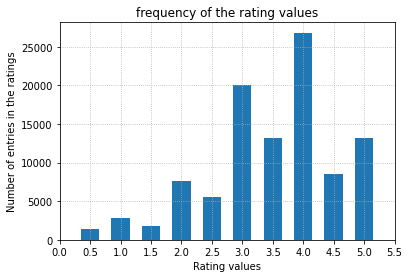

In [7]:
u, indices = np.unique(rating, return_inverse=True)
plt.bar(u, np.bincount(indices), width=0.3)
locs, labels = plt.xticks()
plt.grid(linestyle=':')
plt.xticks(np.arange(0, 6, 0.5))
plt.xlabel('Rating values')
plt.ylabel('Number of entries in the ratings')
plt.title('frequency of the rating values')
plt.show()

From the shape of the histogram, we can see that most of the ratings are ranged from 3.0 to 5.0. It might simply because that there are more people watching the high rating movie. They heard that the movies were great and then watching them and rating them on the website.

On the other hand, the number of integer ratings are more than the number of fractional rating. It might because that voters tend to use integer directly to make it clearly.

### (C) Plot the distribution of the number of ratings received among movies

The X-axis should be the movie index ordered by decreasing frequency and the Y -axis should be the number of ratings the movie has received; ties can broken in any way. A monotonically decreasing trend is expected.

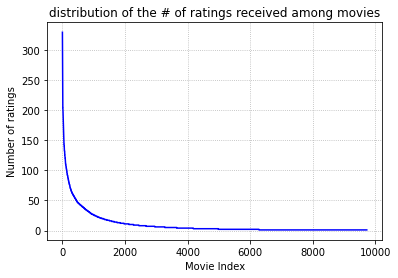

In [8]:
values, counts = np.unique(movie_ID, return_counts=True)
plt.plot(range(1, len(values) + 1), counts[np.argsort(counts)[::-1]], color='b')
plt.grid(linestyle=':')
plt.xlabel('Movie Index')
plt.ylabel('Number of ratings')
plt.title('distribution of the # of ratings received among movies')
plt.show()

### (D) Plot the distribution of ratings among users

The X-axis should be the user index ordered by decreasing frequency and the Y -axis should be the number of movies the user has rated.
The requirement of the plot is similar to that in Question C.

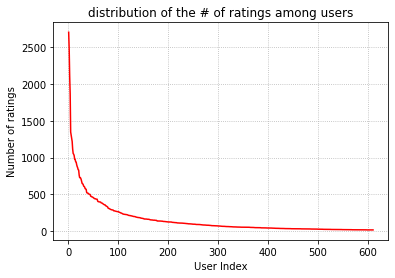

In [9]:
values, counts = np.unique(user_ID, return_counts=True)
plt.plot(range(1, len(values) + 1), counts[np.argsort(counts)[::-1]], color='r')
plt.grid(linestyle=':')
plt.xlabel('User Index')
plt.ylabel('Number of ratings')
plt.title('distribution of the # of ratings among users')
plt.show()

### (E) Discuss the salient features of the distributions
from Questions C,D and their implications for the recommendation process.

From the Question (C), we can see that the majority of the ratings are coming from 500 specific movies approximately. They receive over 50 ratings. Which implies that the majority of the movies don't have enough ratings. It might cause the data imbalance problem if we want to do further analysis.

From the Question (D), we can see that the majority of the ratings are coming from 50 specific users approximately. They give over 500 ratings of movies. Which implies that the majority of the users only give a few raings to some movies. It also indicates the possible data imbalance problem we discovered in Question (C).

In conclusion, it explains why the sparsity of this data are only 0.017. It will face the "Curse of dimensionality" when we proceed to do further high-dimensional analysis are modeling.

### (F) Compute the variance of the rating values received by each movie

Bin the variance values into intervals of width 0.5 and use the binned variance values as the horizontal axis.
Count the number of movies with variance values in the binned intervals and use this count as the vertical axis. Briefly comment on the shape of the resulting histogram.

In [10]:
# set() convert list into distinct elements, and list() change it back to list
u_movie_ID = list(set(movie_ID))
movie_var = []
for i in range(len(u_movie_ID)):
    indices = [ind for ind, x in enumerate(movie_ID) if x == u_movie_ID[i]]
    var = np.var(np.array(rating[indices]))
    movie_var.append(var)

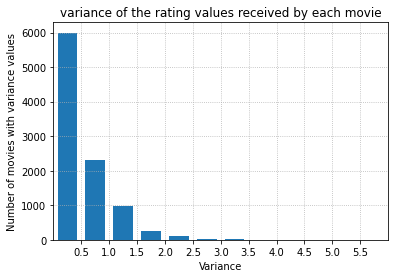

In [11]:
plt.hist(movie_var, bins=np.arange(0, 6, 0.5), rwidth=0.7)
plt.xticks(np.arange(0.5, 6, 0.5))
plt.xlim([0, 6])
plt.grid(linestyle=':')
plt.xlabel('Variance')
plt.ylabel('Number of movies with variance values')
plt.title('variance of the rating values received by each movie')
plt.show()

From the graph, we can see that the majority of the movies have variance less than 1.5. Which makes sense because it's highly possible that users have similar esthetic about popular movies. Considering to the result we found that most of the ratings are coming from small set of movies, this result is expectable.

## Question 2: Understanding the Pearson Correlation Coefficient

- $I_u$ : Set of item indices for which ratings have been specified by user $u$;
- $I_v$ : Set of item indices for which ratings have been specified by user $v$;
- $μ_u$ : Mean rating for user $u$ computed using her specified ratings;
- $r_{uk}$ : Rating of user $u$ for item $k$.

### (A) Write down the formula for $μ_u$ in terms of $I_u$ and $r_{uk}$

<center>$$μ_{u} = \frac{\sum_{k∈I_u}  r_{uk}}{|I_u|}$$ </center>

### (B) In plain words, explain the meaning of $I_u$ ∩ $I_v$. Can $I_u$ ∩ $I_v$ = ∅? (Hint: Rating matrix R is sparse)

$I_u$ ∩ $I_v$ = the set of movies which are both rated by user $u$ and user $v$ 

$I_u$ ∩ $I_v$ can equal to ∅. When $I_u$ ∩ $I_v$ = ∅, it means that there are no movies both rated by user $u$ and user $v$.

## QUESTION 3: Understanding the Prediction function

<center>$$Pearson(u, v) = \frac{\sum_{k\in I_u \cap I_v} (r_{uk}- \mu_u)(r_{vk}- \mu_v)} {\sqrt{\sum_{k\in I_u \cap I_v} (r_{uk}- \mu_u)^2}\sqrt{\sum_{k\in I_u \cap I_v} (r_{vk}- \mu_v)^2}}$$</center>

<br/>

<center>$$\hat{r_{uj}} = \mu_u + \frac{\sum_{v\in P_u} Pearson(u, v)(r_{vj} - \mu_v)}{\sum_{v\in P_u} |Pearson(u, v)|}$$</center>

Can you explain the reason behind mean-centering the raw ratings ($r_{vj}$ − $μ_v$) in the prediction function? (Hint: Consider users who either rate all items highly or rate all items poorly and the impact of these users on the prediction function.)

By using mean-centerting in this prediction function, we can avoid the effects of users who have their own rating discipline. 

For example, some users tend to rate the movie from 3.0 to 5.0, and others might tend to rate it from 1.0 to 4.0. We need this mean-centering method to avoid the bias coming from users.

In short, it's really similar as a normalization method to make sure that all the ratings are scaling in the same scope.

## QUESTION 4

Design a k-NN collaborative filter to predict the ratings of the movies in the original dataset and evaluate its performance using 10-fold cross validation. Sweep $k$ (number of neighbors) from 2 to 100 in step sizes of 2, and for each $k$ compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot average RMSE (Y-axis) against $k$ (X-axis) and average MAE (Y-axis) against $k$ (X-axis).

In [5]:
reader = Reader(line_format='user item rating', sep=',', rating_scale=(0.5, 5), skip_lines=1)
df = pd.read_csv(path + 'ratings.csv')
Reader_ratings_Data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

In [13]:
rmse = []
mae = []
ks = np.arange(2, 102, 2)
for k in ks:
    print('k =', k, '...')
    CV = cross_validate(KNNWithMeans(k=k, sim_options={'name':'pearson'}, 
                                     verbose=False), measures=['rmse','mae'], 
                        data=Reader_ratings_Data, cv=10)   
    rmse.append(np.mean(CV['test_rmse']))
    mae.append(np.mean(CV['test_mae']))

k = 2 ...
k = 4 ...
k = 6 ...
k = 8 ...
k = 10 ...
k = 12 ...
k = 14 ...
k = 16 ...
k = 18 ...
k = 20 ...
k = 22 ...
k = 24 ...
k = 26 ...
k = 28 ...
k = 30 ...
k = 32 ...
k = 34 ...
k = 36 ...
k = 38 ...
k = 40 ...
k = 42 ...
k = 44 ...
k = 46 ...
k = 48 ...
k = 50 ...
k = 52 ...
k = 54 ...
k = 56 ...
k = 58 ...
k = 60 ...
k = 62 ...
k = 64 ...
k = 66 ...
k = 68 ...
k = 70 ...
k = 72 ...
k = 74 ...
k = 76 ...
k = 78 ...
k = 80 ...
k = 82 ...
k = 84 ...
k = 86 ...
k = 88 ...
k = 90 ...
k = 92 ...
k = 94 ...
k = 96 ...
k = 98 ...
k = 100 ...


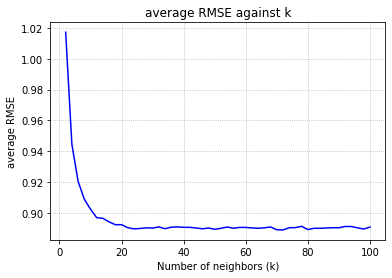

In [14]:
plt.plot(ks, rmse, color='b')
plt.grid(linestyle=':')
plt.ylabel('average RMSE')
plt.xlabel('Number of neighbors (k)')
plt.title('average RMSE against k')
plt.show()

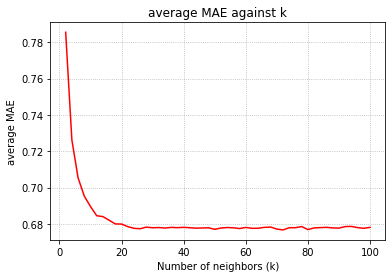

In [15]:
plt.plot(ks, mae, color='r')
plt.grid(linestyle=':')
plt.ylabel('average MAE')
plt.xlabel('Number of neighbors (k)')
plt.title('average MAE against k')
plt.show()

## QUESTION 5

Use the plot from question 4, to find a ’minimum k’. Note: The term ’minimum k’ in this context means that increasing k above the minimum value would not result in a significant
decrease in average RMSE or average MAE. If you get the plot correct, then ’minimum k’ would correspond to the k value for which average RMSE and average MAE converges to a steady-state value. Please report the steady state values of average RMSE and average MAE.

From the graph "average RMSE against k", we can see that it converges to a steady-state value when $k = 20$ approximately.

Therefore, the minimum k of average RMSE is 20, and its corresponding convergent RMSE is approximately 0.89.

From the graph "average MAE against k", we can see that it also converges to a steady-state value when $k = 20$ approximately.

Therefore, the minimum k of average MAE is 20, and its corresponding convergent MAE is approximately 0.68.



## QUESTION 6: Within EACH of the 3 trimmed subsets in the dataset, design (train and validate):

A k-NN collaborative filter on the ratings of the movies (i.e Popular, Unpopular or High-Variance) and evaluate each of the three models’ performance using 10-fold cross validation:

- Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE
(Y-axis) against k (X-axis). Also, report the minimum average RMSE.

In [7]:
def data_trimming(movie_ID, rating):
    pop, unpop, h_var = set(), set(), set()
    
    movies, movies_cnt = np.unique(movie_ID, return_counts=True)
    u_movie_ID = list(set(movie_ID))
    movies_var = []

    for i in range(len(u_movie_ID)):
        indices = [ind for ind, x in enumerate(movie_ID) if x == u_movie_ID[i]]
        var = np.var(np.array(rating[indices]))
        movies_var.append(var)
    
    for i in range(len(movies)):
        if movies_cnt[i] > 2:
            pop.add(movies[i])
        if movies_cnt[i] <= 2:
            unpop.add(movies[i])
        if movies_cnt[i] >= 5 and movies_var[i] >= 2.0:
            h_var.add(movies[i])
    return pop, unpop, h_var

In [8]:
def plot_rmse(ks, rmse, trimset):
  plt.plot(ks, rmse, color='b')
  plt.grid(linestyle=':')
  plt.ylabel('average RMSE')
  plt.xlabel('Number of neighbors (k)')
  plt.title('average RMSE against k using '+str(trimset))
  plt.show()

In [9]:
def k_fold_rmse(dataset, trimming_set, trim_set_name, mod, upper_k):
  kf = KFold(n_splits=10)
  ks = np.arange(2, upper_k, 2)
  RMSE = []
  for k in ks:
    # print('k =', k, '...')
    if mod == 'KNN':
      model = KNNWithMeans(k=k, sim_options={'name': 'pearson'}, verbose=False)
    if mod == 'NMF':
      model = NMF(n_factors=k, verbose=False)
    if mod == 'SVD':
      model = SVD(n_factors=k, n_epochs=20, verbose=False)

    rmse_tmp = []
    for train_set, test_set in kf.split(dataset):
        test_set = list(filter(lambda x: int(x[1]) in trimming_set, test_set))
        model.fit(train_set)
        y_pred = model.test(test_set)
        rmse_tmp.append(accuracy.rmse(y_pred, verbose=False))
    RMSE.append(np.mean(rmse_tmp))
  plot_rmse(ks, RMSE, trim_set_name)
  min_rmse = min(RMSE)
  return min_rmse

In [10]:
def plot_roc_curve(train_set, test_set, trimming_set, trim_set_name, k, thresholds, mod):
  if mod == 'KNN':
    model = KNNWithMeans(k=k, sim_options={'name': 'pearson'}, verbose=False)
  if mod == 'NMF':
    model = NMF(n_factors=k, verbose=False)
  if mod == 'SVD':
    model = SVD(n_factors=k, n_epochs=20, verbose=False)

  if (trim_set_name != 'no trimming'):
    test_set = list(filter(lambda x: int(x[1]) in trimming_set, test_set))
  model.fit(train_set)
  y_pred = model.test(test_set)
  fig, ax = plt.subplots()
  for thres in thresholds:
    scores = []
    for row in y_pred:
        if row.r_ui > thres:
            scores.append(1)
        else:
            scores.append(0)
    fpr, tpr, thresholds = roc_curve(scores, [row.est for row in y_pred])
    ax.plot(fpr, tpr, lw=2, linestyle=':',label="AUC: %0.2f" % auc(fpr,tpr) + ', threshold=' + str(thres)) 
  ax.plot([0, 1], [0, 1], 'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve for ' + str(mod) + ' using minimal k = ' + str(k) + ', using ' + str(trim_set_name))
  plt.legend(loc="lower right")
  plt.show()

In [11]:
Ratings_Data = pd.read_csv(path + "ratings.csv", usecols=['userId','movieId','rating']) 
user_ID = Ratings_Data.pop('userId').values
movie_ID = Ratings_Data.pop('movieId').values
rating = Ratings_Data.pop('rating').values
pop, unpop, h_var = data_trimming(movie_ID, rating)

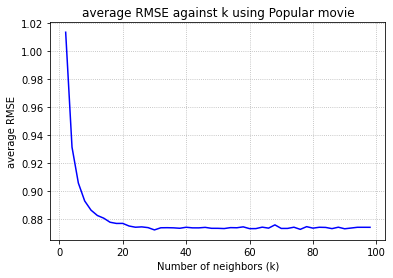

the minimum average RMSE when using Popular movie trimming: 0.8722908665083944


In [21]:
pop_min_rmse = k_fold_rmse(Reader_ratings_Data, pop, 'Popular movie', 'KNN', 100)
print("the minimum average RMSE when using Popular movie trimming:", pop_min_rmse)

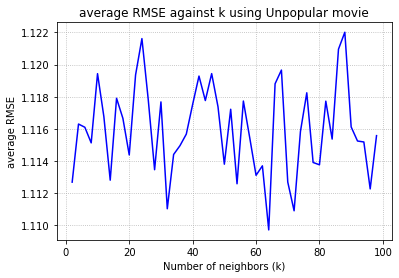

the minimum average RMSE when using Unpopular movie trimming: 1.109724883365493


In [22]:
unpop_min_rmse = k_fold_rmse(Reader_ratings_Data, unpop, 'Unpopular movie', 'KNN', 100)
print("the minimum average RMSE when using Unpopular movie trimming:", unpop_min_rmse)

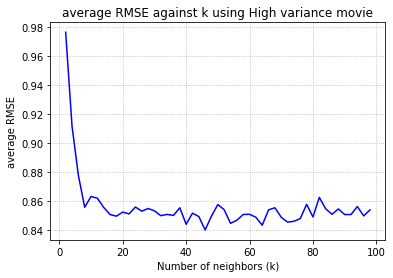

the minimum average RMSE when using High variance movie trimming: 0.8402167209047157


In [23]:
h_var_min_rmse = k_fold_rmse(Reader_ratings_Data, h_var, 'High variance movie', 'KNN', 100)
print("the minimum average RMSE when using High variance movie trimming:", h_var_min_rmse)

- Plot the ROC curves for the k-NN collaborative filters for threshold values [2.5, 3, 3.5, 4]. These thresholds are applied only on the ground truth labels in held-out validation set. For each of the plots, also report the area under the curve (AUC) value. You should have 4 × 4 plots in
this section (4 trimming options – including no trimming times 4 thresholds) - all thresholds can be condensed into one plot per trimming option yielding only 4 plots.

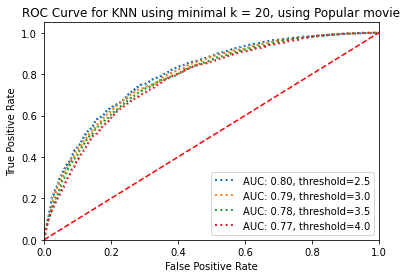

In [24]:
minimal_k = 20
thresholds = [2.5, 3.0, 3.5, 4.0]
train_set, test_set = train_test_split(Reader_ratings_Data, test_size=0.1)
plot_roc_curve(train_set, test_set, pop, 'Popular movie', minimal_k, thresholds, 'KNN')

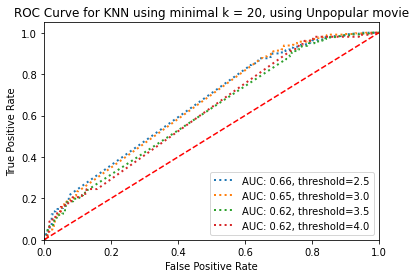

In [25]:
plot_roc_curve(train_set, test_set, unpop, 'Unpopular movie', minimal_k, thresholds, 'KNN')

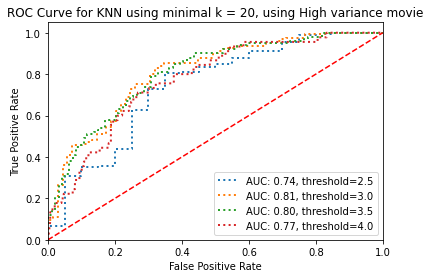

In [26]:
plot_roc_curve(train_set, test_set, h_var, 'High variance movie', minimal_k, thresholds, 'KNN')

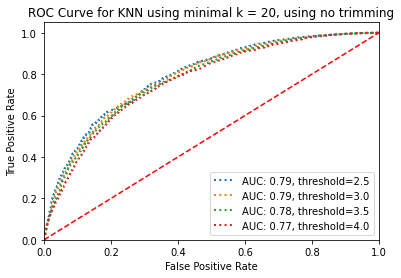

In [27]:
plot_roc_curve(train_set, test_set, pop, 'no trimming', minimal_k, thresholds, 'KNN')

## QUESTION 7: Understanding the NMF cost function: 

$$minimize_{U,V} \sum_{i=1}^m \sum_{j=1}^n W_{ij}(r_{ij} - (UV^T)_{ij})^2$$

Is the optimization problem given by equation 5 convex? Consider the optimization problem given by equation 5. For U fixed, formulate it as a least-squares problem.

The equation is not convex.

Considering the situation that $U, V$ are matrices of dimension $1$ x $1$, $r_{11} = 0$ then $W_{11} = 1$.
The equation now becomes $U^2V^2$.

$det ∇^2(U^2V^2) = -8U^2V^2 \leq 0$, which indicates that the Hessian matrix of it is not positive semi-definite.

$\rightarrow$ This equation is not convex.



## QUESTION 8: Designing the NMF Collaborative Filter:

### (A) Design a NMF-based collaborative filter to predict the ratings of the movies in the original dataset and evaluate its performance using 10-fold cross-validation. 

Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. If NMF takes too long, you can increase the step size. Increasing it too much will result in poorer granularity
in your results. Plot the average RMSE (Y-axis) against k (X-axis) and the average MAE (Yaxis) against k (X-axis). For solving this question, use the default value for the regularization parameter.

In [28]:
rmse = []
mae = []
ks = np.arange(2, 52, 2)
for k in ks:
    print('k =', k, '...')
    CV = cross_validate(NMF(n_factors=k, verbose=False), 
                        measures=['rmse','mae'], 
                        data=Reader_ratings_Data, cv=10)   
    rmse.append(np.mean(CV['test_rmse']))
    mae.append(np.mean(CV['test_mae']))

k = 2 ...
k = 4 ...
k = 6 ...
k = 8 ...
k = 10 ...
k = 12 ...
k = 14 ...
k = 16 ...
k = 18 ...
k = 20 ...
k = 22 ...
k = 24 ...
k = 26 ...
k = 28 ...
k = 30 ...
k = 32 ...
k = 34 ...
k = 36 ...
k = 38 ...
k = 40 ...
k = 42 ...
k = 44 ...
k = 46 ...
k = 48 ...
k = 50 ...


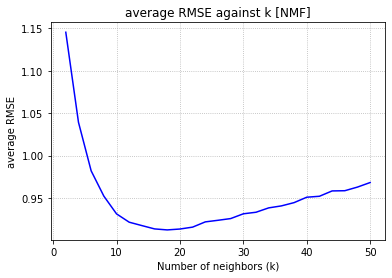

In [29]:
plt.plot(ks, rmse, color='b')
plt.grid(linestyle=':')
plt.ylabel('average RMSE')
plt.xlabel('Number of neighbors (k)')
plt.title('average RMSE against k [NMF]')
plt.show()

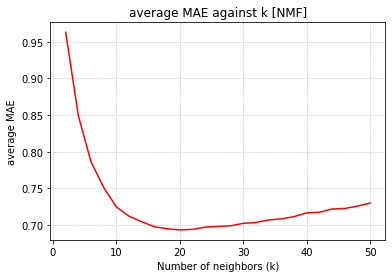

In [30]:
plt.plot(ks, mae, color='r')
plt.grid(linestyle=':')
plt.ylabel('average MAE')
plt.xlabel('Number of neighbors (k)')
plt.title('average MAE against k [NMF]')
plt.show()

### (B) Use the plot from the previous part to find the optimal number of latent factors. 

Optimal number of latent factors is the value of k that gives the minimum average RMSE or the
minimum average MAE. Please report the minimum average RMSE and MAE. Is the optimal number of latent factors same as the number of movie genres?

From the graph "average RMSE against k [NMF]", we can see that the optimal value of latent factors occurs at $k = 18$ approximately.

Therefore, the optimal number of latent factors is 18, and its corresponding convergent RMSE is approximately 0.91.

From the graph "average MAE against k [NMF]", we can see that the optimal value of latent factors occurs at $k = 22$ approximately.

Therefore, the optimal number of latent factors is 20, and its corresponding convergent MAE is approximately 0.69.

Combining these two, the optimal number of latent factors of this data is approximately 20. And from the README.txt file of this dataset, we know the number of movie genres is 18. They are different but pretty close actually.

In [31]:
minimal_k = 20

### (C) Performance on trimmed dataset subsets: 

For each of Popular, Unpopular and High-Variance subsets

- Design a NMF collaborative filter for each trimmed subset and evaluate its performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds.
- Plot average RMSE (Y-axis) against k (X-axis); item Report the minimum average RMSE.

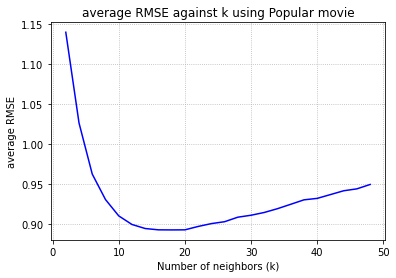

[NMF] the minimum average RMSE when using Popular movie trimming: 0.8929700669696651


In [32]:
pop_min_rmse = k_fold_rmse(Reader_ratings_Data, pop, 'Popular movie', 'NMF', 50)
print("[NMF] the minimum average RMSE when using Popular movie trimming:", pop_min_rmse)

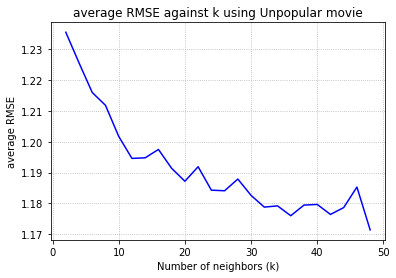

[NMF] the minimum average RMSE when using Unpopular movie trimming: 1.1714378169606676


In [33]:
unpop_min_rmse = k_fold_rmse(Reader_ratings_Data, unpop, 'Unpopular movie', 'NMF', 50)
print("[NMF] the minimum average RMSE when using Unpopular movie trimming:", unpop_min_rmse)

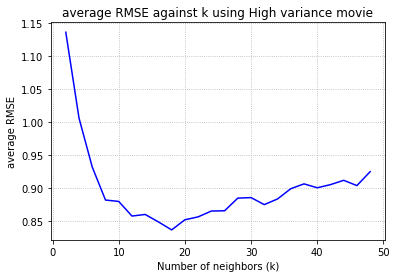

[NMF] the minimum average RMSE when using High variance movie trimming: 0.8364963789030224


In [34]:
h_var_min_rmse = k_fold_rmse(Reader_ratings_Data, h_var, 'High variance movie', 'NMF', 50)
print("[NMF] the minimum average RMSE when using High variance movie trimming:", h_var_min_rmse)

- Plot the ROC curves for the NMF-based collaborative filter and also report the area under the curve (AUC) value as done in Question 6.

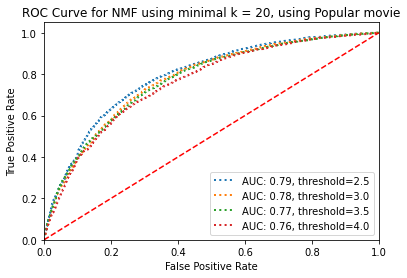

In [35]:
minimal_k = 20
# thresholds = [2.5, 3.0, 3.5, 4.0]
# train_set, test_set = train_test_split(Reader_ratings_Data, test_size=0.1)
plot_roc_curve(train_set, test_set, pop, 'Popular movie', minimal_k, thresholds, 'NMF')

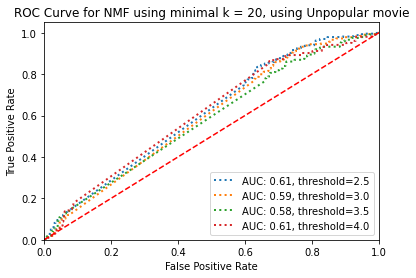

In [36]:
plot_roc_curve(train_set, test_set, unpop, 'Unpopular movie', minimal_k, thresholds, 'NMF')

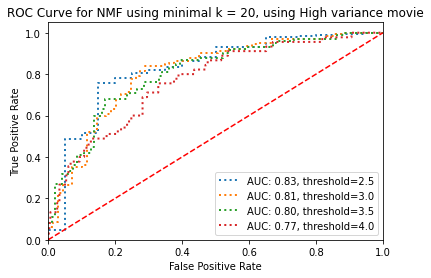

In [37]:
plot_roc_curve(train_set, test_set, h_var, 'High variance movie', minimal_k, thresholds, 'NMF')

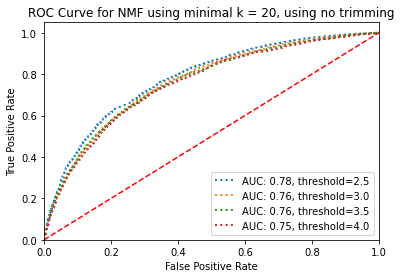

In [38]:
plot_roc_curve(train_set, test_set, pop, 'no trimming', minimal_k, thresholds, 'NMF')

## QUESTION 9: Interpreting the NMF model: 

Perform Non-negative matrix factorization on the ratings matrix R to obtain the factor matrices U and V , where U represents the user-latent factors interaction and V represents the movie-latent factors interaction (use k = 20). For each column of V , sort the movies in descending order and report the genres of the top 10 movies.

In [39]:
genres = pd.read_csv(path + 'movies.csv',usecols=['movieId','title','genres'])
train_set, test_set = train_test_split(Reader_ratings_Data, test_size=0.1)
nmf = NMF(n_factors=20, n_epochs=50, verbose=False)
nmf.fit(train_set).test(test_set)
U = nmf.pu
V = nmf.qi

In [40]:
columns = np.random.choice(20, 10, replace=False)
for c in columns:
    print('Latent factor number:', c)
    sorted_col = np.argsort(V[:, c])[::-1]
    for i in sorted_col[0:10]:
        print(genres['genres'][i])
    print('-'*20)

Latent factor number: 0
Comedy
Drama
Action|Drama|Thriller
Action|Adventure|Fantasy|Sci-Fi
Action|Children|Romance
Comedy|Romance
Drama|Sci-Fi
Drama|Romance
Adventure|Comedy
Documentary
--------------------
Latent factor number: 19
Crime|Drama|Romance
Action|Adventure|Animation
Drama
Drama
Comedy|Romance
Comedy|Drama|Romance
Crime|Drama
Drama
Drama
Crime|Horror|Sci-Fi
--------------------
Latent factor number: 17
Comedy|Drama|Romance
Action|Horror|Sci-Fi
Adventure|Animation|Fantasy|Romance
Adventure|Drama|Romance|Thriller|War
Comedy|Thriller
Action|Fantasy|Horror|Mystery|Sci-Fi|Thriller
Comedy|Drama|Romance
Action|Thriller|War
Adventure|Children|Drama|Fantasy|IMAX
Horror
--------------------
Latent factor number: 12
Crime|Drama|Thriller
Adventure|Animation|Children|Comedy|Fantasy
Comedy|Mystery|Romance
Drama|Fantasy|Mystery|Romance|Thriller
Horror|Romance
Drama
Action|Crime|Drama
Action|Animation|Sci-Fi
Action|Crime|Mystery|Thriller
Comedy|Drama|Romance
--------------------
Latent fact

Do the top 10 movies belong to a particular or a small collection of genre? Is there a connection between the latent factors and the movie genres?


Yes, we can see that there are many columns we selected have this phenomenon. For example, in latent factor 1, 2,and 13, the majority of top 10 movies are coming from Comedy and Drama.

There is a connection between the latent factors and the movie genres. After comparison, we can see that Comedy, Drama, and Action appear most in the random latent factor we selected. And these are also three genres have highest rating.

## QUESTION 10: Designing the MF Collaborative Filter:

### (A) Design a MF-based collaborative filter to predict the ratings of the movies in the original dataset and evaluate it’s performance using 10-fold cross-validation. 

Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE
and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot the average RMSE (Y-axis) against k (X-axis) and the average MAE (Y-axis) against k (X-axis).
For solving this question, use the default value for the regularization parameter.

In [41]:
rmse = []
mae = []
ks = np.arange(2, 52, 2)
for k in ks:
    print('k =', k, '...')
    CV = cross_validate(SVD(n_factors=k, n_epochs=20, verbose=False), 
                        measures=['rmse','mae'], 
                        data=Reader_ratings_Data, cv=10)   
    rmse.append(np.mean(CV['test_rmse']))
    mae.append(np.mean(CV['test_mae']))

k = 2 ...
k = 4 ...
k = 6 ...
k = 8 ...
k = 10 ...
k = 12 ...
k = 14 ...
k = 16 ...
k = 18 ...
k = 20 ...
k = 22 ...
k = 24 ...
k = 26 ...
k = 28 ...
k = 30 ...
k = 32 ...
k = 34 ...
k = 36 ...
k = 38 ...
k = 40 ...
k = 42 ...
k = 44 ...
k = 46 ...
k = 48 ...
k = 50 ...


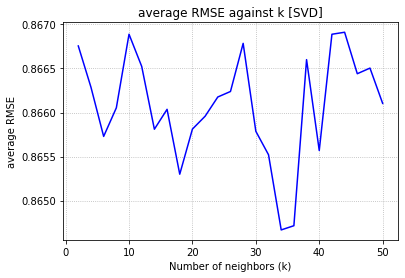

In [42]:
plt.plot(ks, rmse, color='b')
plt.grid(linestyle=':')
plt.ylabel('average RMSE')
plt.xlabel('Number of neighbors (k)')
plt.title('average RMSE against k [SVD]')
plt.show()

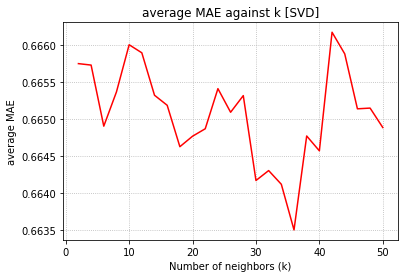

In [43]:
plt.plot(ks, mae, color='r')
plt.grid(linestyle=':')
plt.ylabel('average MAE')
plt.xlabel('Number of neighbors (k)')
plt.title('average MAE against k [SVD]')
plt.show()

### (B) Use the plot from the previous part to find the optimal number of latent factors. 

Optimal number of latent factors is the value of k that gives the minimum average RMSE or the minimum average MAE. Please report the minimum average RMSE and MAE. Is the optimal number of latent factors same as the number of movie genres?

In [44]:
svd_min_rmse = min(rmse)
svd_min_mae = min(mae)
print("Optimal number of latent factor: %d, its coresponding rmse: %0.4f" % 
      (ks[[i for i, x in enumerate(rmse) if x == svd_min_rmse][0]], svd_min_rmse))
print("Optimal number of latent factor: %d, its coresponding mae: %0.4f" % 
      (ks[[i for i, x in enumerate(mae) if x == svd_min_mae][0]], svd_min_mae))

Optimal number of latent factor: 34, its coresponding rmse: 0.8647
Optimal number of latent factor: 36, its coresponding mae: 0.6635


From above graphs, we can see that there are actually no many differences among different k we use. The differences between them are smaller than 0.001.
Which is expected because we know SVD should perform better on high-dimensional dataset based on previous project results we have.

The optimal number of latent factors is different from the number of movie genres. But it should not be a big problem since the differences between them are really tiny as we mentioned.

From the result, we choose optimal number of latent factors = 32 for further experiments. (Since it's closer to # of genres)

In [45]:
minimal_k = 32

### (C) Performance on dataset subsets: 

For each of Popular, Unpopular and High-Variance subsets

- Design a MF collaborative filter for each trimmed subset and evaluate its performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds.

- Plot average RMSE (Y-axis) against k (X-axis); item Report the minimum average RMSE.


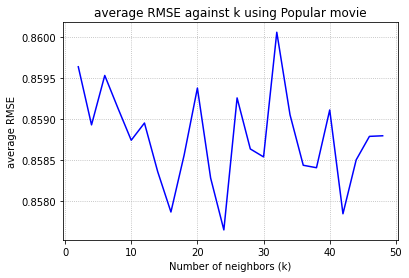

[SVD] the minimum average RMSE when using Popular movie trimming: 0.8576495411550166


In [46]:
pop_min_rmse = k_fold_rmse(Reader_ratings_Data, pop, 'Popular movie', 'SVD', 50)
print("[SVD] the minimum average RMSE when using Popular movie trimming:", pop_min_rmse)

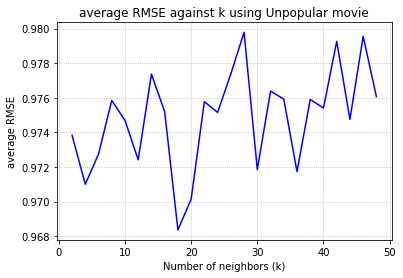

[SVD] the minimum average RMSE when using Unpopular movie trimming: 0.9683642477633152


In [47]:
unpop_min_rmse = k_fold_rmse(Reader_ratings_Data, unpop, 'Unpopular movie', 'SVD', 50)
print("[SVD] the minimum average RMSE when using Unpopular movie trimming:", unpop_min_rmse)

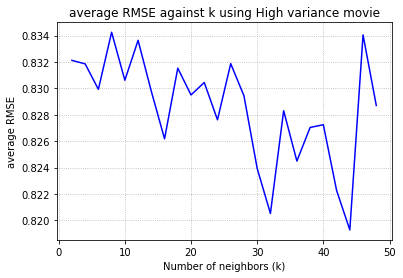

[SVD] the minimum average RMSE when using High variance movie trimming: 0.8192759765175465


In [48]:
h_var_min_rmse = k_fold_rmse(Reader_ratings_Data, h_var, 'High variance movie', 'SVD', 50)
print("[SVD] the minimum average RMSE when using High variance movie trimming:", h_var_min_rmse)

- Plot the ROC curves for the MF-based collaborative filter and also report the area under the curve (AUC) value as done in Question 6.

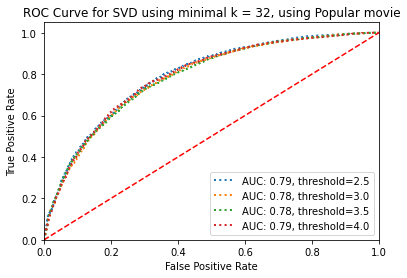

In [49]:
minimal_k = 32
# thresholds = [2.5, 3.0, 3.5, 4.0]
# train_set, test_set = train_test_split(Reader_ratings_Data, test_size=0.1)
plot_roc_curve(train_set, test_set, pop, 'Popular movie', minimal_k, thresholds, 'SVD')

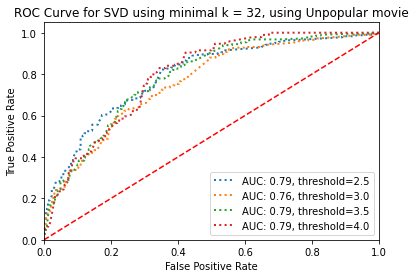

In [50]:
plot_roc_curve(train_set, test_set, unpop, 'Unpopular movie', minimal_k, thresholds, 'SVD')

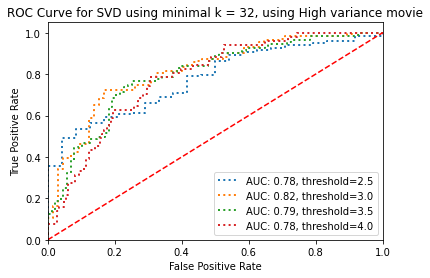

In [51]:
plot_roc_curve(train_set, test_set, h_var, 'High variance movie', minimal_k, thresholds, 'SVD')

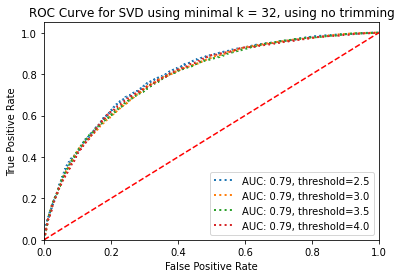

In [52]:
plot_roc_curve(train_set, test_set, pop, 'no trimming', minimal_k, thresholds, 'SVD')

## QUESTION 11: Designing a Naive Collaborative Filter:

- Design a naive collaborative filter to predict the ratings of the movies in the original dataset and evaluate it’s performance using 10-fold cross validation. Compute the average RMSE by averaging the RMSE across all 10 folds. Report the average RMSE.

In [53]:
# set() convert list into distinct elements, and list() change it back to list
u_user_ID = list(set(user_ID))
rating_mean = []
for i in range(len(u_user_ID)):
    # indices = np.where(user_ID == u_user_ID[i])
    indices = [ind for ind, x in enumerate(user_ID) if x == u_user_ID[i]]
    mean = np.mean(np.array(rating[indices]))
    rating_mean.append(mean)

In [54]:
kf = KFold(n_splits=10)
n_rmse = []
for train_set, test_set in kf.split(Reader_ratings_Data):
    y_pred = [rating_mean[int(row[0]) - 1] for row in test_set]
    y_true = [row[2] for row in test_set]
    n_rmse.append(mean_squared_error(y_true, y_pred, squared=False))
Naive_rmse = np.mean(n_rmse)
print("average RMSE of naive collaborative filter:", Naive_rmse)

average RMSE of naive collaborative filter: 0.9347148493195837


- Performance on dataset subsets: For each of Popular, Unpopular and High-Variance test subsets
  - Design a naive collaborative filter for each trimmed set and evaluate its performance using 10-fold cross validation.
  - Compute the average RMSE by averaging the RMSE across all 10 folds. Report the average RMSE.

In [12]:
def naive_rmse(dataset, trimming_set, trim_set_name):
  kf = KFold(n_splits=10)
  
  n_rmse = []
  for train_set, test_set in kf.split(dataset):
      test_set = list(filter(lambda x: int(x[1]) in trimming_set, test_set))
      y_pred = [rating_mean[int(row[0]) - 1] for row in test_set]
      y_true = [row[2] for row in test_set]
      n_rmse.append(mean_squared_error(y_true, y_pred, squared=False))
  
  naive_avg_rmse = np.mean(n_rmse)
  return naive_avg_rmse

In [56]:
pop_naive_rmse = naive_rmse(Reader_ratings_Data, pop, 'Popular movie')
print("[SVD] the minimum average RMSE when using Popular movie trimming:", pop_naive_rmse)

[SVD] the minimum average RMSE when using Popular movie trimming: 0.9323172697573952


In [57]:
unpop_naive_rmse = naive_rmse(Reader_ratings_Data, unpop, 'Unpopular movie')
print("[SVD] the minimum average RMSE when using Unpopular movie trimming:", unpop_naive_rmse)

[SVD] the minimum average RMSE when using Unpopular movie trimming: 0.9711231830351148


In [58]:
h_var_naive_rmse = naive_rmse(Reader_ratings_Data, h_var, 'Unpopular movie')
print("[SVD] the minimum average RMSE when using High variance movie trimming:", h_var_naive_rmse)

[SVD] the minimum average RMSE when using High variance movie trimming: 0.9218560979549629


## QUESTION 12: Comparing the most performant models across architecture: 

Plot the best ROC curves (threshold = 3) for the k-NN, NMF, and MF with bias based collaborative filters in the same figure.

In [13]:
def helper(model, train_set, test_set, threshold):
  model.fit(train_set)
  y_pred = model.test(test_set)
  scores = []
  for row in y_pred:
      if row.r_ui > threshold:
          scores.append(1)
      else:
          scores.append(0)
  fpr, tpr, thresholds = roc_curve(scores, [row.est for row in y_pred])
  return fpr, tpr, thresholds

In [14]:
def plot_all_roc_curve(train_set, test_set, knnK, nmfK, svdK, threshold):
  fig, ax = plt.subplots()

  model = KNNWithMeans(k=knnK, sim_options={'name': 'pearson'}, verbose=False)
  fpr, tpr, thresholds = helper(model, train_set, test_set, threshold)
  ax.plot(fpr, tpr, lw=2, linestyle=':',label="AUC: %0.2f" % auc(fpr,tpr) + ', KNN using k=' + str(knnK))
  print("KNN AUC:", auc(fpr,tpr))

  model = NMF(n_factors=nmfK, verbose=False)
  fpr, tpr, thresholds = helper(model, train_set, test_set, threshold)
  ax.plot(fpr, tpr, lw=2, linestyle=':',label="AUC: %0.2f" % auc(fpr,tpr) + ', NMF using k=' + str(nmfK)) 
  print("NMF AUC:", auc(fpr,tpr))

  model = SVD(n_factors=svdK, n_epochs=20, verbose=False)
  fpr, tpr, thresholds = helper(model, train_set, test_set, threshold)
  ax.plot(fpr, tpr, lw=2, linestyle=':',label="AUC: %0.2f" % auc(fpr,tpr) + ', SVD using k=' + str(svdK))
  print("SVD AUC:", auc(fpr,tpr))

  ax.plot([0, 1], [0, 1], 'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve for different models using their best parameter (k)')
  plt.legend(loc="lower right")
  plt.show()

KNN AUC: 0.7797373849441157
NMF AUC: 0.766220825115056
SVD AUC: 0.7839918022682445


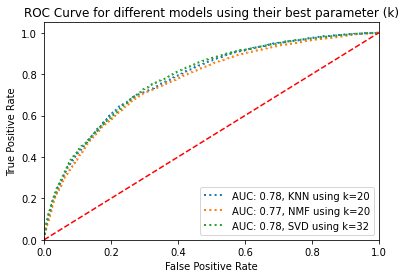

In [61]:
train_set, test_set = train_test_split(Reader_ratings_Data, test_size=0.1)
best_knn_k = 20
best_nmf_k = 20
best_svd_k = 32
plot_all_roc_curve(train_set, test_set, best_knn_k, best_nmf_k, best_svd_k, 3.0)

Use the figure to compare the performance of the filters in predicting the ratings of the movies.

From the graph, we can see that SVD performs best, which is what we expect because we know SVD should perform better in high-dimensional data. (According to the result we learned from previous project.)

On the other hand, KNN performs a little bit worse than SVD and NMF performs the worst. But the difference between them is still tiny. It might because that this data already reach an limit considering to its complexity. We choose the best parameter to use these models and they all converge to a similar value.

If we want to increase the accuracy, we might consider preprocessing the data or using ensemble method to achieve it. Adjusting other hyperparameters of the models is also a way to improve it.



## QUESTION 13: Understanding Precision and Recall in the context of Recommender Systems: 

$S(t)$ : The set of items of size t recommended to the user.

$G$: The set of items liked by the user (ground-truth positives)

$$Precision(t) = \frac{|S(t)| \cap G}{|S(t)|}$$

$$Recall(t) = \frac{|S(t)| \cap G}{|G|}$$

Precision and Recall are defined by the mathematical expressions given by equations 12 and 13 respectively. Please explain the meaning of precision and recall in your own words.

Precision is relevant to the accuracy of our prediction. If it's low, it indicates that the false positive rate is high. In recommendation system, it shows the percentage of items that are truly liked by users out of the recommendation list. The intersection of recommended list and true list means $True Positive (TP)$. Recommended list predicted as true means $TP + FP$.

Recall is similar to sensitivity. It also indicates high false positive rate if it's low. In recommendation system, it shows whether the items user likes were recommended or not. The intersection of recommended list and true list means $True Positive (TP)$. Actual true ($G$) = $TP + FN$.

## QUESTION 14: Comparing the precision-recall metrics for the different models:

For each of the three architectures:

- Plot average precision (Y-axis) against t (X-axis) for the ranking obtained using the model’s predictions.

- Plot the average recall (Y-axis) against t (X-axis) and plot the average precision (Y-axis) against average recall (X-axis).

- Use the best k found in the previous parts and sweep t from 1 to 25 in step sizes of 1. For each plot, briefly comment on the shape of the plot.


In [20]:
# def pr(y_pred, t, threshold):
#     user_est_true = defaultdict(list)
#     for user_id, _, y_true, est, _ in y_pred:
#         user_est_true[user_id].append((est, y_true))

#     precisions = dict()
#     recalls = dict()

#     for user_id, user_ratings in user_est_true.items():
#         user_ratings.sort(key=lambda x: x[0], reverse=True)

#         # 𝑆(𝑡): The set of items of size t recommended to the user.
#         S = sum((est >= threshold) for (est, y_true) in user_ratings[:t])
#         # 𝐺: The set of items liked by the user (ground-truth positives)
#         G = sum((y_true >= threshold) for (est, y_true) in user_ratings)


#         SandG = sum(((y_true >= threshold) and (est >= threshold)) 
#                       for (est, y_true) in user_ratings[:t])
#         precisions[user_id] = SandG / S if S != 0 else 1
#         recalls[user_id] = SandG / G if G != 0 else 1

#     return precisions, recalls

In [22]:
def plot_score(ts, score, score_name, mod):
  plt.plot(ts, score, color='b')
  plt.grid(linestyle=':')
  plt.ylabel(str(score_name))
  plt.xlabel('t')
  plt.title('average ' + str(score_name) + ' against t using ' + str(mod))
  plt.show()

In [40]:
def plot_pre_cal(mod, k, ts, dataset, threshold):
  if mod == 'KNN':
    model = KNNWithMeans(k=k, sim_options={'name': 'pearson'}, verbose=False)
  if mod == 'NMF':
    model = NMF(n_factors=k, verbose=False)
  if mod == 'SVD':
    model = SVD(n_factors=k, n_epochs=20, verbose=False)

  precisions = []
  recalls = []
  for t in ts:
    # print('t =', t, '...')
    kf = KFold(n_splits=10)
    tmp_p = []
    tmp_r = []
    for train_set, test_set in kf.split(dataset):
      # 𝐺: The set of items liked by the user (ground-truth positives)
      G = {}
      for user_id, movie_id, rating in test_set:
          if user_id in G.keys():
              if rating >= 3.0:
                  G[user_id].add(movie_id)
          else:
              G[user_id] = set()
              if rating >= 3.0:
                  G[user_id].add(movie_id)    
      user_movie = {}
      for user_id, movie_id, rating in test_set:
          if user_id in user_movie.keys():
              user_movie[user_id].append(movie_id)
          else:
              user_movie[user_id] = []
              user_movie[user_id].append(movie_id)

      test_set = [row for row in test_set if (len(user_movie[row[0]]) >= t and len(G[row[0]]) > 0)]
      model.fit(train_set)
      y_pred = model.test(test_set)
      user_est = {}
      for index, user_id, y_true, est, _ in y_pred:
          if index in user_est.keys():
              user_est[index].append((user_id, est))
          else:
              user_est[index] = []
              user_est[index].append((user_id, est))
      _p = []
      _r = []
      for uid in user_est.keys():
          S = user_est[uid]
          S = sorted(S, key = lambda x : x[1], reverse=True)
          # 𝑆(𝑡): The set of items of size t recommended to the user.
          S_t = set([row[0] for row in S[0:t]])
          _p.append(len(S_t.intersection(G[uid])) / float(len(S_t)))
          _r.append(len(S_t.intersection(G[uid])) / float(len(G[uid])))
    
      tmp_p.append(np.mean(_p))
      tmp_r.append(np.mean(_r))
    precisions.append(np.mean(np.array(tmp_p)))
    recalls.append(np.mean(np.array(tmp_r)))

  # precision against t
  plot_score(ts, precisions, 'precision', mod)  
  # recall against t
  plot_score(ts, recalls, 'recall', mod)
  # precision against recall
  plt.plot(recalls, precisions, color='b')
  plt.grid(linestyle=':')
  plt.ylabel('precision')
  plt.xlabel('recall')
  plt.title('average precision against average recall using ' + str(mod))
  plt.show()

  return precisions, recalls

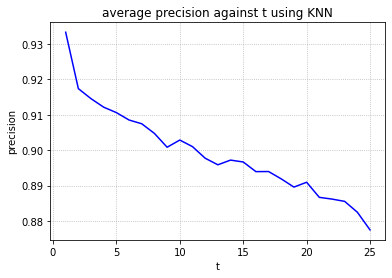

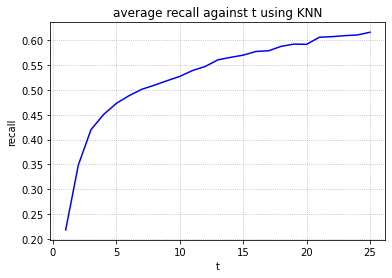

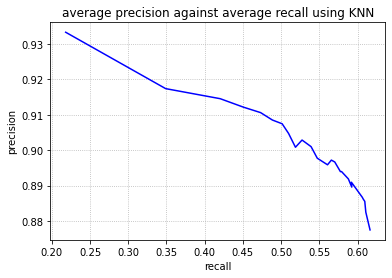

In [41]:
ts = np.arange(1, 26, 1)
best_knn_k = 20
best_nmf_k = 20
best_svd_k = 32
knn_p, knn_r = plot_pre_cal('KNN', best_knn_k, ts, Reader_ratings_Data, 3.0)

From the graph, we can see that the average precision decreases as t increases. It's expected because thee False positive rate should increase as there are more number of items being recommended.

On the other hand, the average recall increases as t increases. It makes sense because we know $|S(t)|$ increases as t increases, it causes $|S(t)| \cap G$ getting larger as well. Also, recall is more sensitive to t as t increases.

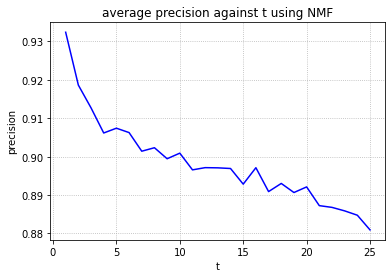

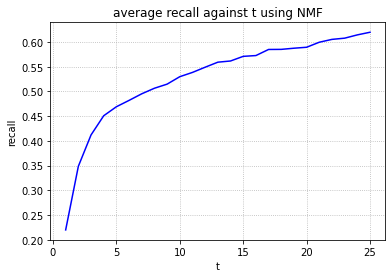

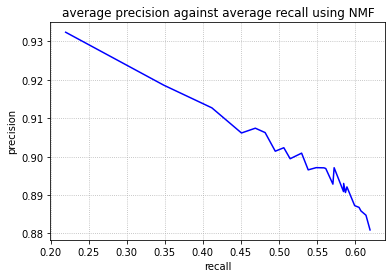

In [42]:
nmf_p, nmf_r = plot_pre_cal('NMF', best_nmf_k, ts, Reader_ratings_Data, 3.0)

From the graph, it's similar to KNN. 

we can see that the average precision decreases as t increases. It's expected because thee False positive rate should increase as there are more number of items being recommended.

On the other hand, the average recall increases as t increases. It makes sense because we know $|S(t)|$ increases as t increases, it causes $|S(t)| \cap G$ getting larger as well. Also, recall is more sensitive to t as t increases.

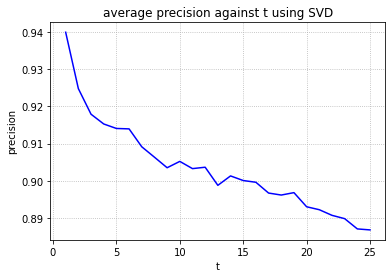

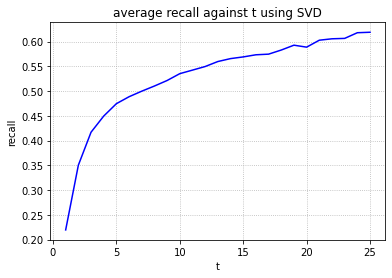

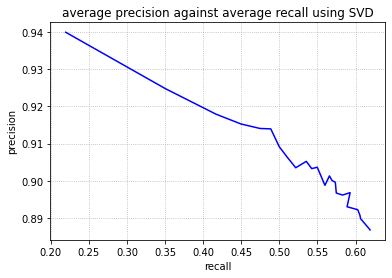

In [43]:
svd_p, svd_r = plot_pre_cal('SVD', best_svd_k, ts, Reader_ratings_Data, 3.0)

From the graph, it's similar to KNN and NMF. 

we can see that the average precision decreases as t increases. It's expected because thee False positive rate should increase as there are more number of items being recommended.

On the other hand, the average recall increases as t increases. It makes sense because we know $|S(t)|$ increases as t increases, it causes $|S(t)| \cap G$ getting larger as well. Also, recall is more sensitive to t as t increases.

- Plot the best precision-recall curves obtained for the three models (k-NN, NMF, MF) in the same figure. Use this figure to compare the relevance of the recommendation list generated using k-NN, NMF, and MF with bias predictions.

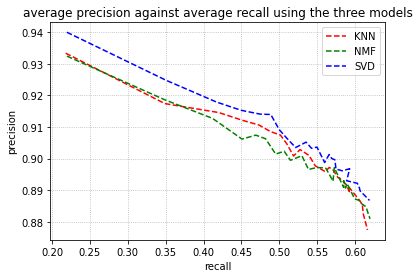

In [44]:
fig, ax = plt.subplots()
ax.plot(knn_r, knn_p, 'r--', label='KNN')
ax.plot(nmf_r, nmf_p, 'g--', label='NMF')
ax.plot(svd_r, svd_p, 'b--', label='SVD')
plt.grid(linestyle=':')
plt.ylabel('precision')
plt.xlabel('recall')
plt.legend(loc='best')
plt.title('average precision against average recall using the three models')
plt.show()

From the graph above, it still indicates that SVD performs better when using precision/recall criteria. Because its precision drops slower as its recall increases. Furthermore, KNN also performs second here and NMF performs the worst. Nonetheless, it should be noted that the differences among them are still not huge.

In short, we can say that SVD provides us a most relevant recommendation list to the user.